In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from ems_data import EMSData
from neural_network import MLP

In [2]:
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

NVIDIA GeForce GTX 1070


device(type='cuda')

In [3]:
# Get X_train, X_dev, X_test, y_train, y_dev, y_test
ems_data = EMSData.load_instance('ems_data.pkl')
n_stations = len(ems_data.stations)
n_demand_nodes = len(ems_data.demand_nodes)
demand = ems_data.demand_nodes.demand
dataset = pd.read_csv('dataset.csv')
X = dataset[[f'station{i}' for i in range(n_stations)]].to_numpy()
y = dataset[[f'coverage{i}' for i in range(n_demand_nodes)]].to_numpy()
X = torch.tensor(X, dtype=torch.float32, device=device)
y = torch.tensor(y, dtype=torch.float32, device=device)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.75)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, random_state=0, train_size=2/3)
X_train.shape, X_dev.shape, X_test.shape, y_train.shape, y_dev.shape, y_test.shape

(torch.Size([50000, 46]),
 torch.Size([25000, 46]),
 torch.Size([25000, 46]),
 torch.Size([50000, 67]),
 torch.Size([25000, 67]),
 torch.Size([25000, 67]))

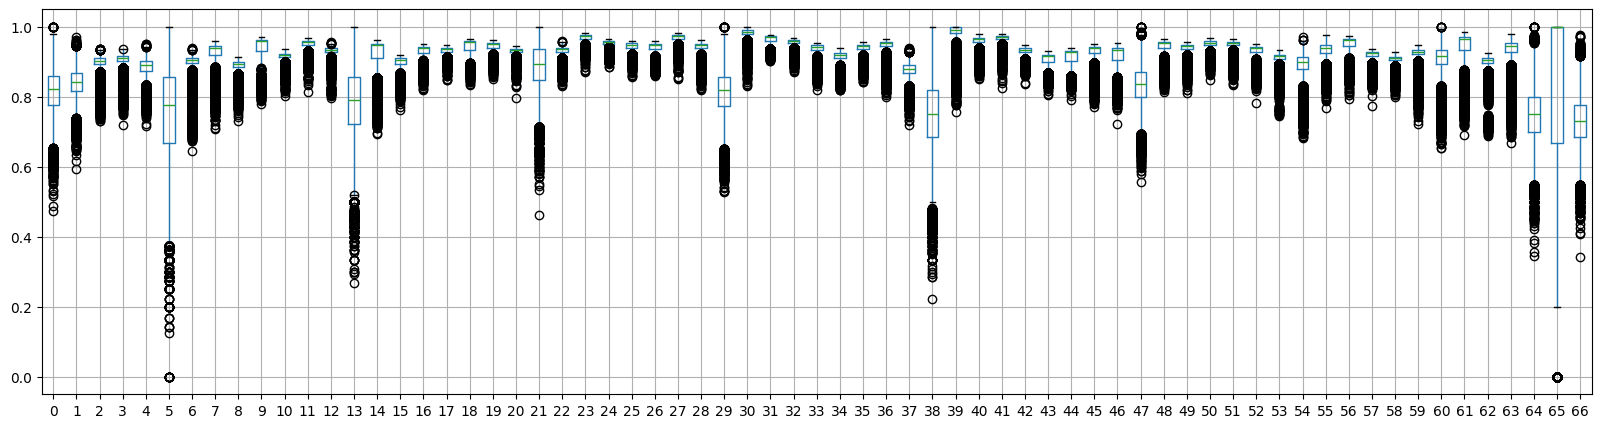

Average coverages: [0.8182689  0.84064984 0.89867157 0.90604734 0.8833693  0.76290596
 0.89938164 0.92610896 0.8892661  0.9423441  0.915245   0.95163786
 0.93181086 0.78778917 0.927537   0.8988636  0.93060213 0.9326773
 0.9459215  0.9447311  0.9304768  0.88853    0.9326454  0.97037774
 0.953558   0.94465685 0.9416529  0.9700147  0.94136727 0.8146611
 0.9813103  0.96494734 0.9556731  0.9384703  0.914581   0.9394768
 0.94615597 0.87638545 0.74955773 0.98267347 0.9595925  0.9676125
 0.93204015 0.9078195  0.9152799  0.93008065 0.91737986 0.83396435
 0.9465301  0.9412958  0.95166415 0.9502049  0.93108904 0.9117736
 0.8887922  0.932452   0.95244604 0.91986924 0.90669984 0.9229424
 0.907078   0.94489795 0.8973317  0.9324947  0.7476814  0.8030595
 0.72994804]
Long-term overall coverage of best training sample: 0.9504503386477956


In [4]:
# EDA of the targets
y_train_ = y_train.cpu().numpy()  # Only do y_train because y takes a while to plot

y_df = pd.DataFrame(y_train_)
y_df.boxplot(figsize=(20, 5))
plt.show()

print(f"Average coverages: {y_train_.mean(axis=0)}")
sim_scores = y_train_@demand / demand.sum()
print(f"Long-term overall coverage of best training sample: {sim_scores.max()}")

In [5]:
# Overall coverage statistics
sim_scores.mean(), sim_scores.std(), np.median(sim_scores), sim_scores.min(), sim_scores.max()

(0.941320898542417,
 0.0032145288673266826,
 0.9416252288732867,
 0.923521312936705,
 0.9504503386477956)

When evaluating the ML model, we are interested in how well it predicts overall coverage $d'y$. More specifically:
- We only care about how the model performs when embedded in the MIP. The MIP implements a modified version of the sigmoid, $\min\{\sigma(z), 0.25z + 0.5\}$, therefore when evaluating the neural net, we must use the same modified sigmoid function during inference.
- Our top priority is to not overestimate coverage. Although it would be unfortunate for the true optimum (the solution with the highest true coverage) to be predicted as having much lower coverage than it actually does, the opposite scenario (low true coverage, predicted as having high coverage) is much worse as this could cause the MIP's objective function to overestimate a solution's coverage, resulting in the MIP returning a poor quality solution. We measure $d'\hat{y} - d'y$, where $\hat{y}$ is predicted and $y$ is ground truth. The goal of training is to get the prediction $\hat{y}$ to be close to $y$. We would additionally like the worst case difference $d'\hat{y} - d'y$ between predicted and ground truth coverage to be small.

In [6]:
# Load the neural net
mlp = MLP.load_model('model.pt').to(device)
mlp

MLP(
  (0): Linear(in_features=46, out_features=200, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.0, inplace=False)
  (3): Linear(in_features=200, out_features=67, bias=True)
)

total demand: 297700
************************* LinearRegression *************************
true coverage statistics:
    mean: 280217.6293104615
    std: 960.0978536019231
    median: 280317.7671340406
    min: 274415.56631338596
    max: 282679.420302093


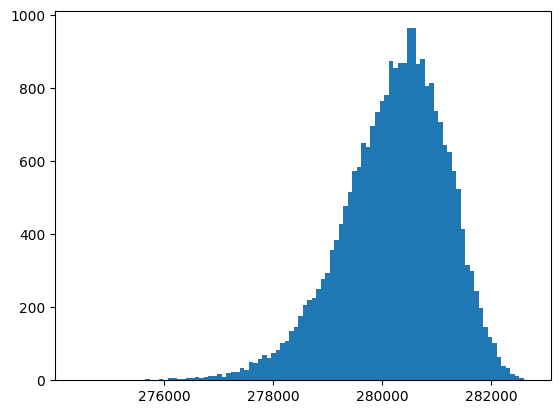

predicted coverage statistics:
    mean: 280221.68967954227
    std: 292.5303209061729
    median: 280213.5709762573
    min: 279145.49812316895
    max: 281399.7593078613


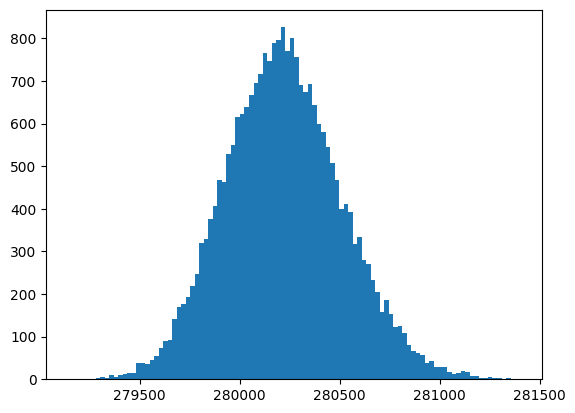

coverage difference (predicted - true) statistics:
    mean: 4.060369080747366
    std: 914.2175978290732
    median: -85.95781806111336
    min: -2547.15444624424
    max: 5820.858493447304


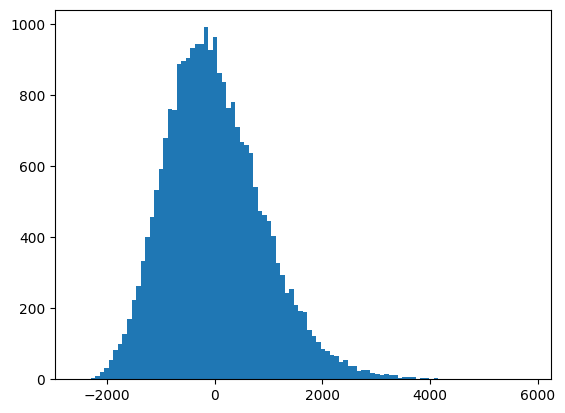

coverage difference above 50 statistics:
    mean: 824.6617424138599
    std: 653.7974982087884
    median: 664.44830301404
    min: 50.09127014875412
    max: 5820.858493447304


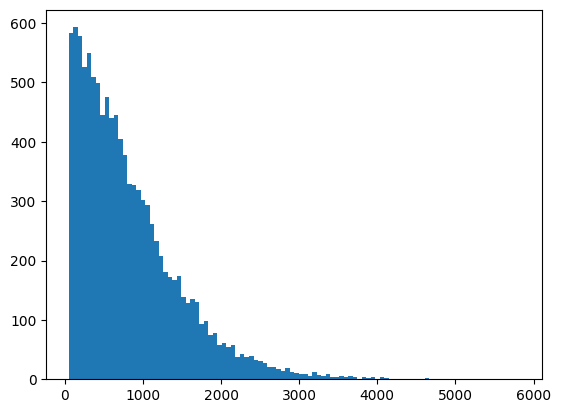

************************* DecisionTreeRegressor *************************
true coverage statistics:
    mean: 280217.6293104615
    std: 960.0978536019231
    median: 280317.7671340406
    min: 274415.56631338596
    max: 282679.420302093


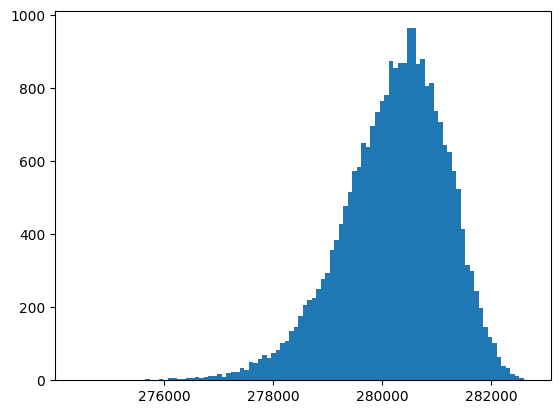

predicted coverage statistics:
    mean: 280257.2259740566
    std: 941.1911351672783
    median: 280339.03923268616
    min: 275055.8271021843
    max: 282949.06581544876


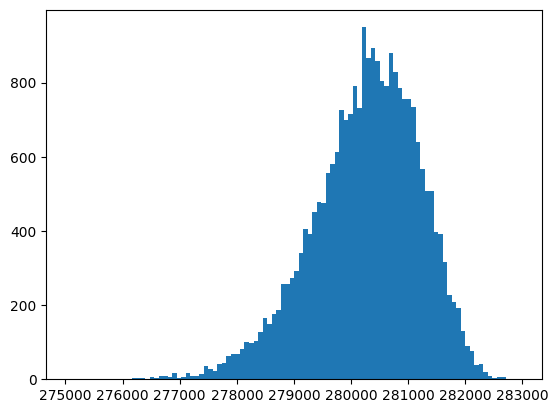

coverage difference (predicted - true) statistics:
    mean: 39.59666359509766
    std: 1106.8038894086858
    median: 32.75731994211674
    min: -4775.986449122429
    max: 5831.926406383514


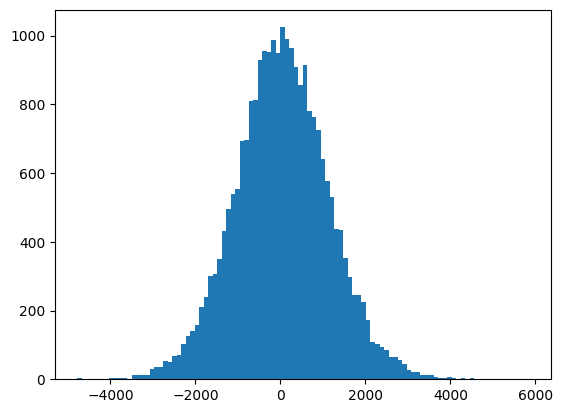

coverage difference above 50 statistics:
    mean: 921.0003844804396
    std: 689.2471000694597
    median: 773.6544078588486
    min: 50.006384551525116
    max: 5831.926406383514


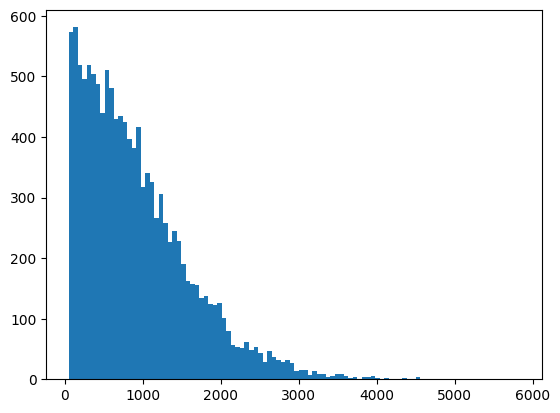

************************* MLP *************************


Predicting: 100%|██████████| 196/196 [00:00<00:00, 1031.60it/s]


true coverage statistics:
    mean: 280217.6293104615
    std: 960.0978536019231
    median: 280317.7671340406
    min: 274415.56631338596
    max: 282679.420302093


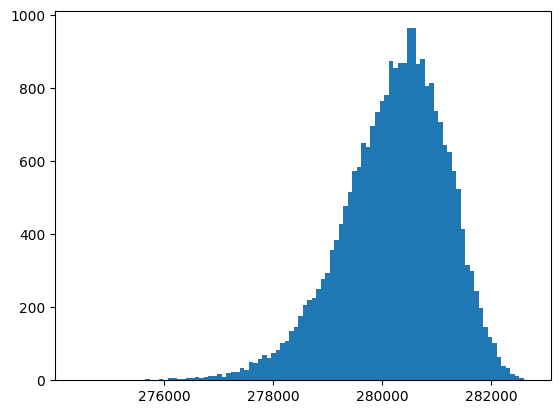

predicted coverage statistics:
    mean: 280419.12328222196
    std: 823.1417829028368
    median: 280509.5175500512
    min: 276163.3973288238
    max: 282417.95888248086


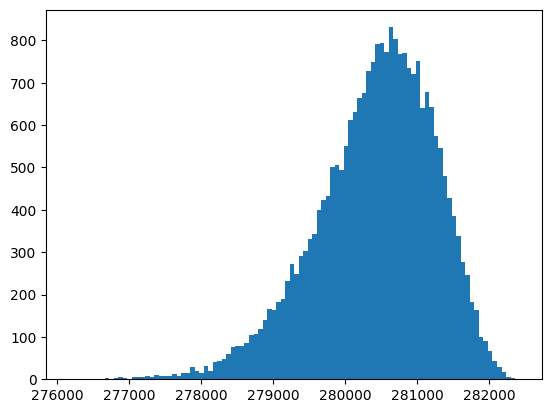

coverage difference (predicted - true) statistics:
    mean: 201.49397176052452
    std: 412.79428145758664
    median: 177.96014666557312
    min: -2221.3006016612053
    max: 3438.7735561728477


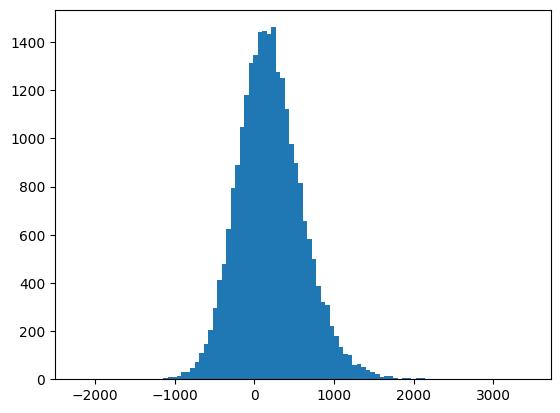

coverage difference above 50 statistics:
    mean: 439.2534513525933
    std: 306.90724818252943
    median: 371.7336250394583
    min: 50.06117391586304
    max: 3438.7735561728477


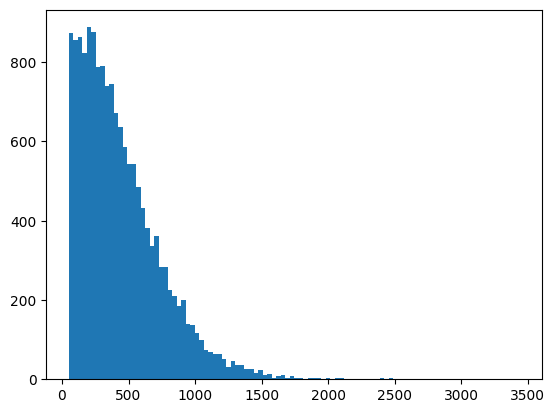

In [7]:
# Benchmark linear regression, decision tree, and the neural net on the test set
def print_statistics_and_plot_histogram(values, name):
    print(f"{name} statistics:")
    print(f"    mean: {values.mean()}")
    print(f"    std: {values.std()}")
    print(f"    median: {np.median(values)}")
    print(f"    min: {values.min()}")
    print(f"    max: {values.max()}")
    plt.hist(values, bins=100)
    plt.show()

print(f"total demand: {demand.sum()}")
true_coverage = y_test.cpu().numpy()@demand
for model in [LinearRegression(), DecisionTreeRegressor(), mlp]:
    print(f"************************* {model.__class__.__name__} *************************")
    if model == mlp:
        # MIP uses modified sigmoid, so we evaluate the same way
        y_pred = model.predict(X_test, modified_sigmoid=True).cpu().numpy()
    else:
        model.fit(X_train.cpu().numpy(), y_train.cpu().numpy())
        y_pred = model.predict(X_test.cpu().numpy())
    predicted_coverage = y_pred@demand
    coverage_diff = predicted_coverage - true_coverage
    print_statistics_and_plot_histogram(true_coverage, "true coverage")
    print_statistics_and_plot_histogram(predicted_coverage, "predicted coverage")
    print_statistics_and_plot_histogram(coverage_diff, "coverage difference (predicted - true)")
    print_statistics_and_plot_histogram(coverage_diff[coverage_diff > 50], "coverage difference above 50")

The neural net's performance over the whole dataset is inadequate. While its predictions are close on average, the worst case difference between our prediction and ground truth is what matters when embedding it in the MIP. We want to understand how bad this worst case difference is, and whether poorly predicted samples lie in small clusters or are evenly distributed throughout the dataset.

We first use PCA project samples to 3D and color code them by $d'\hat{y} - d'y$. It would be nice to observe that poorly predicted samples tend to cluster together, however if this does not happen, it would not necessarily be bad news (it's possible that in the original feature space, poorly predicted samples cluster together, but this gets lost when projecting down to 3D).

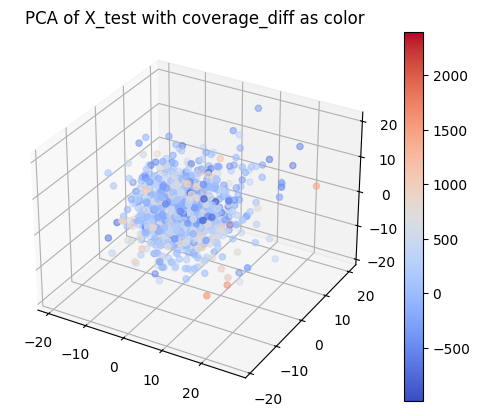

In [8]:
# Use PCA to project samples to 3D and color co
n_samples = 1000  # Can only plot so many points

pca = PCA(n_components=3)
X_3d = pca.fit_transform(X_test.cpu().numpy()[:n_samples])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=coverage_diff[:n_samples], cmap='coolwarm')
plt.colorbar(sc)
plt.title("PCA of X_test with coverage_diff as color")
plt.show()

From PCA, it seems like the red points (inputs where the neural net overestimates coverage) are evenly distributed among the blue points (inputs where the neural net underestimates coverage), which is not a good sign.

The next test is to apply k-means clustering to the dataset, then seeing how poorly predicted samples (specifically the top 10% worst samples) are distributed among the clusters. We would like to see that most poorly predicted points end up in a few clusters, however if they are distributed evenly throughout all clusters then this is bad news.

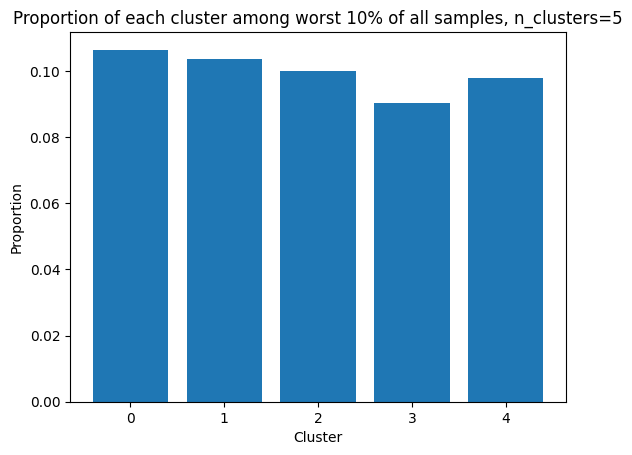

[0.1064578  0.10353307 0.09987277 0.09039725 0.09789851]


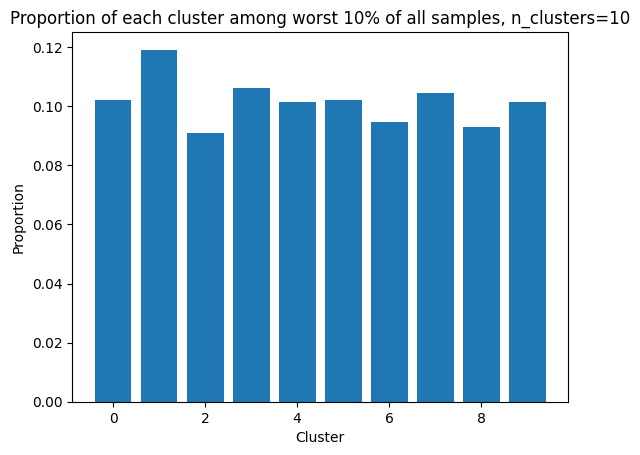

[0.1022349  0.11916584 0.09090909 0.10628743 0.10162003 0.10229939
 0.09469154 0.10449268 0.09293971 0.10139356]


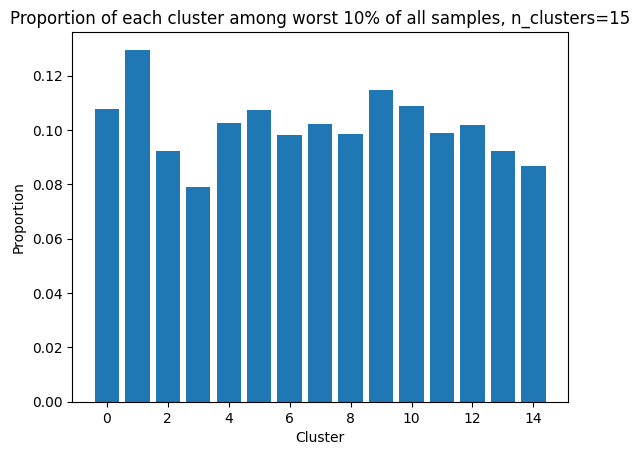

[0.10783699 0.12959113 0.0921659  0.0792277  0.10251188 0.10754098
 0.0980782  0.10234114 0.09850374 0.11478731 0.10905486 0.0987984
 0.10186418 0.09244884 0.08690112]


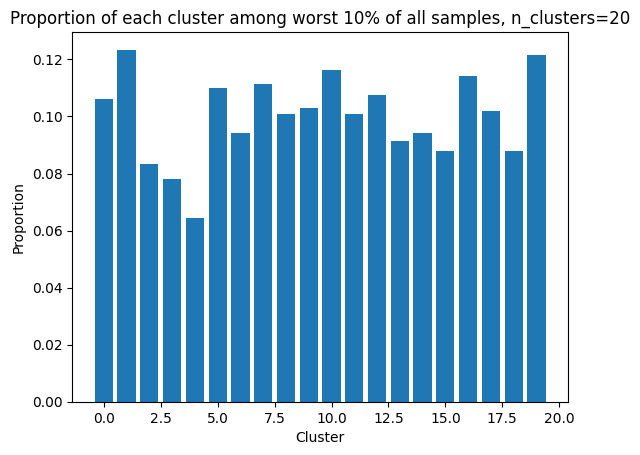

[0.10614525 0.12340426 0.08320373 0.07796102 0.06445993 0.10984848
 0.09436834 0.11137821 0.10093897 0.10301508 0.1161859  0.10081301
 0.10748408 0.0913884  0.0942492  0.08774704 0.11414791 0.10191083
 0.08804523 0.12169312]


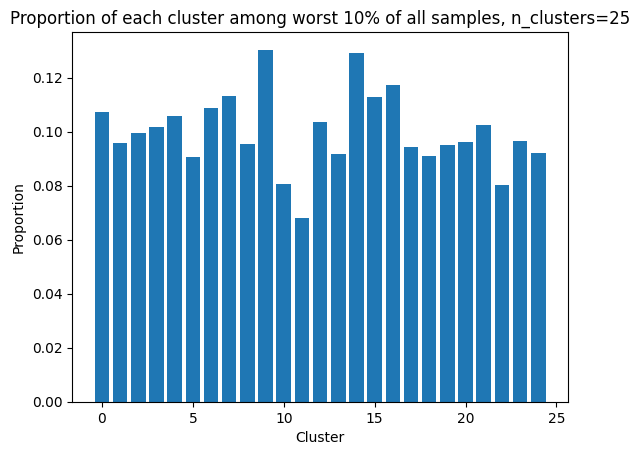

[0.10732197 0.09589041 0.09939148 0.10177866 0.10568295 0.09063444
 0.10879849 0.11334002 0.09537299 0.13039014 0.08050436 0.06818182
 0.1037037  0.09174312 0.129      0.11306043 0.11727749 0.09447236
 0.09090909 0.0952381  0.09617373 0.10266535 0.08036623 0.09641026
 0.09202454]


In [9]:
def kmeans_analysis(X, y_diff, n_clusters=5, percentile=90, random_state=0):
    """Apply k-means to dataset, see how the worst (100-percentile)% of samples are distributed across clusters."""
    # Apply k-means to dataset, see how samples are distributed across clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    kmeans.fit(X)
    all_clusters = kmeans.predict(X)
    all_counts = np.bincount(all_clusters)

    # See how the worst samples are distributed across clusters
    X_worst = X[y_diff > np.percentile(y_diff, percentile)]
    worst_clusters = kmeans.predict(X_worst)
    worst_counts = np.bincount(worst_clusters)

    return all_counts, worst_counts

def plot_bar_graph(heights, title, xlabel, ylabel):
    plt.bar(range(len(heights)), heights)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

percentile = 90
for n_clusters in [5, 10, 15, 20, 25]:
    all_counts, worst_counts = kmeans_analysis(X_test.cpu().numpy(), coverage_diff, n_clusters=n_clusters, percentile=percentile, random_state=0)
    proportions = np.array(worst_counts) / np.array(all_counts)
    plot_bar_graph(proportions, f"Proportion of each cluster among worst {100-percentile}% of all samples, n_clusters={n_clusters}", "Cluster", "Proportion")
    print(proportions)

While not distributed evenly across all clusters, the bad samples are at least somewhat prevalent in all of them.

We look at using a classifier to predict whether the regression model will perform poorly on a sample. Using the original (regression) dataset and the neural net's predictions, we create binary labels, 1 for if a sample is among the worst 10% of all samples (worst w.r.t. $d'\hat{y} - d'y$), 0 if it is not. Note that this is an imbalanced classification task, so as a baseline, the classifier should have accuracy at least 90% (Zero Rule).

We first try decision tree and random forest.

In [10]:
# Binary labels, 1 if coverage_diff in 90th percentile, 0 otherwise
y_bad = (coverage_diff > np.percentile(coverage_diff, 90)).astype(int)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_test.cpu().numpy(), y_bad, random_state=0, train_size=0.5)

# Decision tree classifier
# class_weight='balanced' to account for class imbalance
dt = DecisionTreeClassifier(class_weight='balanced', random_state=0)
dt.fit(X_train_clf, y_train_clf)
y_pred_clf = dt.predict(X_test_clf)
accuracy = accuracy_score(y_test_clf, y_pred_clf)
clf_report = classification_report(y_test_clf, y_pred_clf)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{clf_report}")

Accuracy: 0.83856
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     11266
           1       0.19      0.19      0.19      1234

    accuracy                           0.84     12500
   macro avg       0.55      0.55      0.55     12500
weighted avg       0.84      0.84      0.84     12500



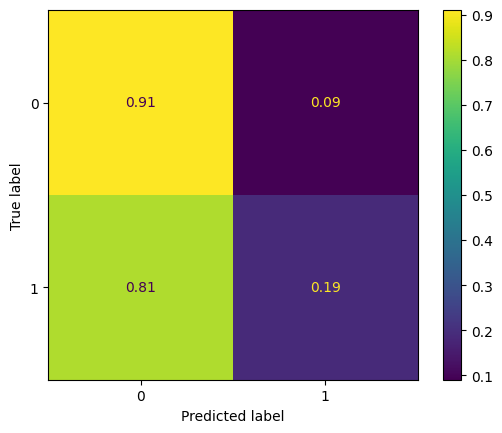

In [11]:
cm = confusion_matrix(y_test_clf, y_pred_clf, normalize='true')
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [12]:
# Decision tree classifier with hyperparameter tuning
param_grid = {
    'max_depth': [None, 25, 50],
    'ccp_alpha': [0.0, 0.1, 1.0]
}
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_clf, y_train_clf)
print(f"Best parameters: {grid_search.best_params_}")
dt = grid_search.best_estimator_
y_pred_clf = dt.predict(X_test_clf)
accuracy = accuracy_score(y_test_clf, y_pred_clf)
clf_report = classification_report(y_test_clf, y_pred_clf)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{clf_report}")

Best parameters: {'ccp_alpha': 0.0, 'max_depth': 25}
Accuracy: 0.83368
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91     11266
           1       0.19      0.21      0.20      1234

    accuracy                           0.83     12500
   macro avg       0.55      0.55      0.55     12500
weighted avg       0.84      0.83      0.84     12500



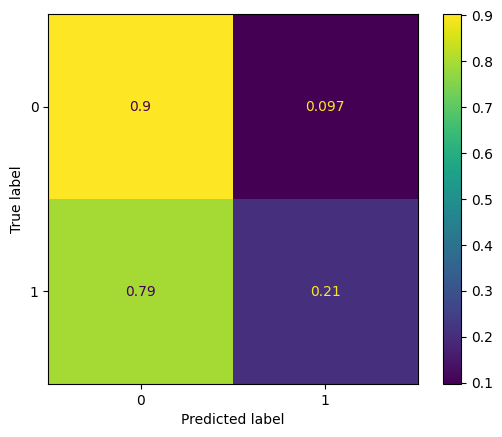

In [13]:
cm = confusion_matrix(y_test_clf, y_pred_clf, normalize='true')
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [14]:
# Random forest classifier
rf = RandomForestClassifier(class_weight='balanced', random_state=0)
rf.fit(X_train_clf, y_train_clf)
y_pred_clf = rf.predict(X_test_clf)
accuracy = accuracy_score(y_test_clf, y_pred_clf)
clf_report = classification_report(y_test_clf, y_pred_clf)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{clf_report}")

Accuracy: 0.90128
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     11266
           1       0.00      0.00      0.00      1234

    accuracy                           0.90     12500
   macro avg       0.45      0.50      0.47     12500
weighted avg       0.81      0.90      0.85     12500



c:\Users\Zach\Documents\Research\MLP4ALP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Zach\Documents\Research\MLP4ALP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Zach\Documents\Research\MLP4ALP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [15]:
# Random forest classifier
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train_clf, y_train_clf)
y_pred_clf = rf.predict(X_test_clf)
accuracy = accuracy_score(y_test_clf, y_pred_clf)
clf_report = classification_report(y_test_clf, y_pred_clf)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{clf_report}")

Accuracy: 0.90128
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     11266
           1       0.00      0.00      0.00      1234

    accuracy                           0.90     12500
   macro avg       0.45      0.50      0.47     12500
weighted avg       0.81      0.90      0.85     12500



c:\Users\Zach\Documents\Research\MLP4ALP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Zach\Documents\Research\MLP4ALP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Zach\Documents\Research\MLP4ALP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

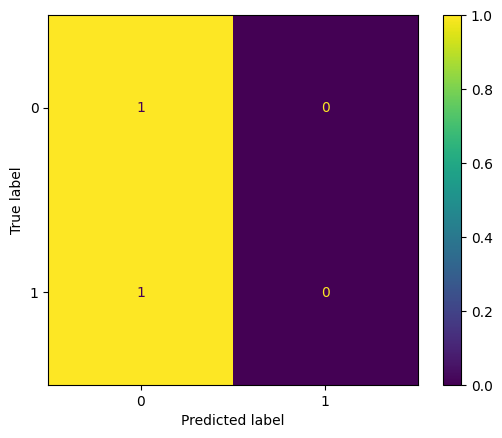

In [16]:
cm = confusion_matrix(y_test_clf, y_pred_clf, normalize='true')
ConfusionMatrixDisplay(cm).plot()
plt.show()